In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.offline as po
import seaborn as sns
import matplotlib.pyplot as plt 
import os 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error


# Training data import

In [2]:
df = pd.read_csv('_raw/case1Data.txt')

# Training data prep

In [3]:
# NA values are by default strings, since there is a space in front
df = df.replace(' NaN', np.nan)

# ensure numeric dtype

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# isolate targets from the design matrix
y = df['y']
X = df.iloc[:,1::]

# for convenience, fix the column naming
# with no spaces

X.columns = [name.replace(' ', '') for name in X.columns]

cat_cols = [col for col in X.columns if 'C' in col]
cat_cols.remove('C_2') # because the training data only contains one label

# Imputation of missing values


In [4]:
# function to impute NaN
def knn_imputer(X, n_neighbors, cat_cols):
    X_knn = X.copy()
    # using same preprocessing as before in order to maintain same recipe (continous variables)
    X_knn_cont = X_knn.loc[:,[col for col in X_knn.columns if 'x' in col]]
    X_knn_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_knn_cont), columns=X_knn_cont.columns)

    # performing one-hot encoding before KNN imputation in order to avoid the model to assume some sort of ordinal relationship
    onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # one hot encoding
    onehot_data = onehot.fit_transform(X_knn[cat_cols])
    onehot_columns = onehot.get_feature_names_out()

    # new df
    onehot_cat_df = pd.DataFrame(onehot_data, columns=onehot_columns)

    X_knn_scaled = pd.concat([X_knn_cont,onehot_cat_df], axis=1)
    # dropping the nan column
    X_knn_scaled = X_knn_scaled.drop(columns={'C_1_nan'})

    # KNNImputer
    knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights="uniform")

    # Apply to dataset
    imputed_data = knn_imputer.fit_transform(X_knn_scaled)

    imputed_df = pd.DataFrame(imputed_data, columns=X_knn_scaled.columns)

    return imputed_df

# Nested CV procedure

In [5]:
# transform y
y = preprocessing.StandardScaler().fit_transform(np.reshape(y.values, (-1,1))).ravel()


In [7]:
# Since RMSE is the required scoring parameter
# define RMSE scorer function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# make it into a default scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)


# Define the models
models = {
    'RandomForest': RandomForestRegressor(criterion='squared_error'),
    'ElasticNet': ElasticNet(max_iter=10000,
                             tol=0.001),
    'LinearRegression': LinearRegression()
}

# RF parameters to investigate
n_estimators = [10,25,50,100]
max_depth = [5, 10, 15,20, 25]
min_samples_leaf = [2, 4, 10]
min_samples_split = [2,4,10]

# ElNet parameters to investigate
alpha = np.logspace(-3,3,7)
l1_ratio = np.linspace(0.5,1,10)

# Define parameter grids for hyperparameter tuning
param_grids = {
    'RandomForest': {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_leaf':min_samples_leaf,
                    'min_samples_split':min_samples_split},
    'ElasticNet': {'alpha': alpha,
                   'l1_ratio': l1_ratio},
    'LinearRegression': {}

}

# try LOOCV for both inner and outer loops (could be costly :D)
outer_cv = LeaveOneOut()
inner_cv = 10

nested_scores = []
model_name = []
k_neighbors = []
cv_results = []

for k in [3,5,8]:
    # rename design matrix for ease of use
    X_final = knn_imputer(X, k, cat_cols=cat_cols)


    for name, model in models.items():
        # Outer Loop
        for train_index, test_index in outer_cv.split(X_final):
            print(test_index)
            X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Grid search inner loop
            grid_search = GridSearchCV(estimator=model, 
                                    param_grid=param_grids[name], 
                                    cv=inner_cv, 
                                    scoring=rmse_scorer,
                                    #verbose=2
                                    )
            grid_search.fit(X_train, y_train)

            # Evaluate on the test data
            y_pred = grid_search.predict(X_test)
            test_rmse = rmse(y_test, y_pred)
            nested_scores.append(test_rmse)
            model_name.append(name)
            cv_results.append(grid_search.best_params_)
            k_neighbors.append(k)

            #print(grid_search.best_params_)

        #Report nested cross-validation RMSE
        nested_rmse = np.mean(nested_scores)
        print("Nested CV RMSE:", nested_rmse)


[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
Nested CV RMSE: 0.529097895059227
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[

In [20]:
df_cv = pd.DataFrame(cv_results)

In [21]:
df_cv[['rmse','model','k_neighbors']] = pd.DataFrame([nested_scores, model_name, k_neighbors]).T

In [19]:
#df_cv.to_excel('_raw/nestedCV_results.xlsx', index=False)

## Nested CV result analysis

In [31]:
df_cv = pd.read_excel('_raw/nestedCV_results.xlsx')

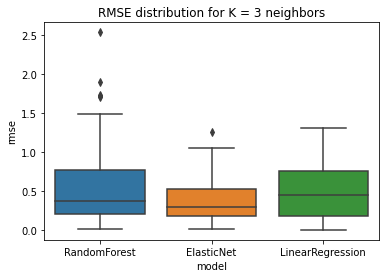

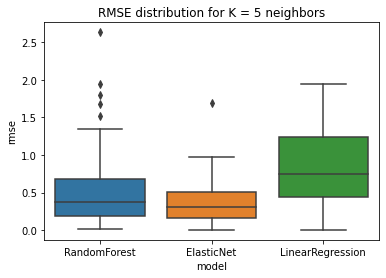

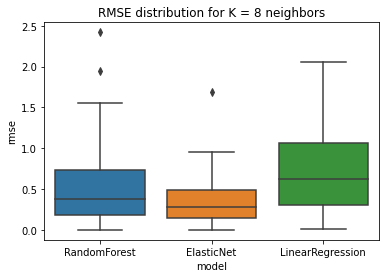

In [23]:
for k in df_cv.k_neighbors.unique():
    fig, ax = plt.subplots()
    sns.boxplot(
        data=df_cv.loc[df_cv.k_neighbors == k],
        x='model',
        y= 'rmse'
    )
    plt.title(f'RMSE distribution for K = {k} neighbors')
    plt.show()

In [26]:
# look at the mean RMSE values
df_cv[['k_neighbors','model','rmse']].groupby(by = ['k_neighbors','model'], as_index=False).mean().sort_values(by='rmse')

k_neighbors             model      rmse
3            5        ElasticNet  0.351457
6            8        ElasticNet  0.351481
0            3        ElasticNet  0.367227
1            3  LinearRegression  0.485563
8            8      RandomForest  0.496515
5            5      RandomForest  0.522693
2            3      RandomForest  0.529098
7            8  LinearRegression  0.699857
4            5  LinearRegression  0.810934

In [30]:
#what is the target range?
y.max() - y.min()



5.361916954610165

## modeling stages:

- Do the LOOCV nested, for hyperparam optimization
- once best params determined, test best param models for estimating RMSE using LOOCV outer loop
- Fit the best performing model with all the training data - use this model to predict X_new

In [21]:
nested_scores

[0.4202945779911676,
 0.3457760333403089,
 0.5205464570880851,
 0.3374199814356506,
 0.48613837163204976,
 0.4403306297265095,
 0.275580294520037,
 0.34552415162908107,
 0.37573966319947805,
 0.46242571763305174]

In [4]:
# only 4 out of 100 cols are complete.
# the rest contain NA's and require a decision on how to handle it
df.loc[:,df.isna().sum(axis=0) == 0].columns

Index(['y', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5'], dtype='object')

Text(0, 0.5, '#NA per column')

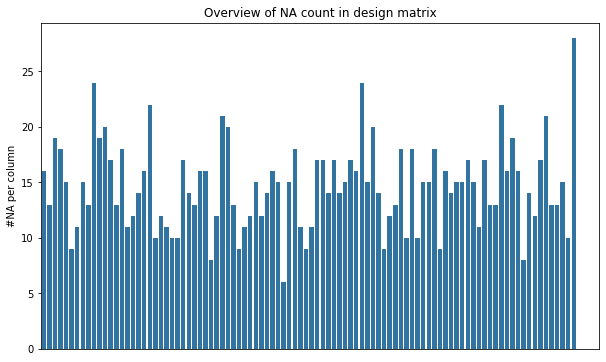

In [7]:
# what to do about the NA's?
nas = X.isna().sum(axis=0)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(
    
    x=nas.index,
    y= nas.values,
    color='tab:blue',

)
plt.title('Overview of NA count in design matrix')
plt.xticks([])
plt.ylabel('#NA per column')

For any given column 10-25% of data is missing. In total, ~14% of data is missing. In this case, the choice of how to fill NA's will have a significant impact on the models performance. The first, simplest choice is to impute the columns mean or a majority label.

## Use column mean or majority for NA

In [8]:
# look into the categorical attributes
cat_cols = [col for col in X.columns if 'C' in col]
for col in cat_cols:
    print(X[col].value_counts())
    print('-'*10)

 J    23
 G    18
 H    12
 I    11
 K     8
Name: C_1, dtype: int64
----------
 H    100
Name: C_2, dtype: int64
----------
 J    26
 G    21
 K    21
 I    16
 H    16
Name: C_3, dtype: int64
----------
 K    24
 G    24
 J    20
 I    20
 H    12
Name: C_4, dtype: int64
----------
 K    24
 I    24
 J    19
 H    17
 G    16
Name: C_5, dtype: int64
----------


C_1 is the only one missing lables. C_2 is redundant as it only contains a single lable (H), so should not be included in the model.

In [9]:
# fill missing data

X_mean = X.copy()
for col in X_mean.columns:
    if 'x' in col: 
        # impute mean for continuous
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].mean())
    else:
        # impute majority group for categorical
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].value_counts().index[0]) 

## Scale and encode attribute data

In [10]:
# drop C_2 from cat_cols
cat_cols.remove('C_2')

In [11]:
X_cont = X_mean.loc[:,[col for col in X_mean.columns if 'x' in col]]
X_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_cont), columns=X_cont.columns)
X_scaled = pd.concat([X_cont,pd.get_dummies(X_mean[cat_cols])], axis=1)

In [12]:
X_scaled

x_1       x_2           x_3       x_4           x_5       x_6  \
0   1.208626e-15  0.000000  2.013601e+00  1.090246  5.439675e-01  1.238584   
1   6.983175e-01 -0.144005  5.227784e-01  0.078762  1.958793e+00  1.949235   
2  -1.902184e+00 -0.074197  1.307966e-01  0.134436  3.885536e-02  0.350106   
3   2.634566e+00 -0.604329  9.089690e-02  1.086510  1.923120e+00 -1.015659   
4   4.245698e-01  0.000000  2.145321e+00  0.616044  3.625686e-01 -0.765803   
..           ...       ...           ...       ...           ...       ...   
95  2.275262e-01  1.171230  6.444114e-01 -0.627415  1.374446e-15 -0.329834   
96 -1.124048e+00 -0.946810 -7.600873e-01 -0.986996 -8.727656e-01 -0.074669   
97  1.023399e+00 -0.577438 -4.105121e-01  0.353594 -8.052793e-01  0.135594   
98 -1.279526e+00 -0.558466 -6.202788e-16 -0.526967 -4.718385e-01 -1.310155   
99 -3.710577e-01 -1.925381 -6.667639e-01  0.496362  1.187166e+00 -0.330276   

             x_7       x_8           x_9          x_10  ...  C_4_ G  C_4_ H  \
0   3.842614e-01  0.319772  3.322680e-01  6.545004e-16  ...       0       0   
1  -4.450169e-01  0.000000  9.135559e-01  4.184132e-01  ...       1       0   
2   5.242694e-01 -0.327886  9.387376e-01  1.064744e+00  ...       0       1   
3  -1.976761e+00  1.106461 -1.127875e+00 -7.314475e-01  ...       0       0   
4  -5.951899e-01  0.000000 -9.559252e-01  2.822050e-01  ...       0       0   
..           ...       ...           ...           ...  ...     ...     ...   
95 -3.387880e-15  0.153868 -6.778659e-16  1.426949e+00  ...       1       0   
96 -1.275224e+00 -2.475271 -3.922758e-01 -1.029843e+00  ...       0       0   
97  1.924016e-01  2.093797  8.794103e-01  1.365966e+00  ...       0       0   
98  1.865909e-01 -0.928186 -6.778659e-16 -1.890162e+00  ...       0       1   
99 -1.194608e+00  0.843194 -6.778659e-16  3.532287e-01  ...       0       0   

    C_4_ I  C_4_ J  C_4_ K  C_5_ G  C_5_ H  C_5_ I  C_5_ J  C_5_ K  
0        0       0       1       0       0       0       1       0  
1        0       0       0       1       0       0       0       0  
2        0       0       0       1       0       0       0       0  
3        0       0       1       1       0       0       0       0  
4        0       0       1       0       1       0       0       0  
..     ...     ...     ...     ...     ...     ...     ...     ...  
95       0       0       0       1       0       0       0       0  
96       1       0       0       0       0       0       0       1  
97       0       0       1       0       0       0       1       0  
98       0       0       0       1       0       0       0       0  
99       1       0       0       0       0       1       0       0  

[100 rows x 115 columns]

# General considerations:

- We should remember that we do the imputations within each fold of the cross-validation.
- We could consider algorithms like decision trees (Random Forest lecture 7/3 or gradient boosting) since it can split the nodes to handle these NaNs and hereby we don't need to impute.
- We should include the terms MCAR, MAR, and NMAR. For example, that NMAR is difficult for us to determine whether this is present due to the lack of domain knowledge in the dataset etc. (https://stefvanbuuren.name/fimd/sec-MCAR.html) (https://medium.com/analytics-vidhya/different-types-of-missing-data-59c87c046bf7). This also makes it difficult for us to choose the correct imputation. It's also a bit difficult to check for MAR since we have 100 variables and we don't know what the different variables are (like the actual meaning of the given variable). In other words, we don't know which variables that are logically related to each other such as function of the lungs and smoking habits. 

# General considerations PART 2:

- Are we allowed to use PCA (we have a lecture about it after hand-in)?
- Due to our limited dataset we could consider a 10 fold cross validation or a leave-one-out?
- For the Random forest I'm looking at the OOB error due to the limited dataset.
- Should we consider another criteria than squared error? Perhaps we could do an outlier investigation? (I have investigated both criterions for the random forest)

# Use KNN imputation for NaN

In [13]:
X_knn = X.copy()
# using same preprocessing as before in order to maintain same recipe (continous variables)
X_knn_cont = X_knn.loc[:,[col for col in X_knn.columns if 'x' in col]]
X_knn_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_knn_cont), columns=X_knn_cont.columns)

# performing one-hot encoding before KNN imputation in order to avoid the model to assume some sort of ordinal relationship
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# one hot encoding
onehot_data = onehot.fit_transform(X_knn[cat_cols])
onehot_columns = onehot.get_feature_names_out()

# new df
onehot_cat_df = pd.DataFrame(onehot_data, columns=onehot_columns)

X_knn_scaled = pd.concat([X_knn_cont,onehot_cat_df], axis=1)
# dropping the nan column
X_knn_scaled = X_knn_scaled.drop(columns={'C_1_nan'})

# KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Apply to dataset
imputed_data = knn_imputer.fit_transform(X_knn_scaled)

imputed_df = pd.DataFrame(imputed_data, columns=X_knn_scaled.columns)

In [15]:
imputed_df

x_1       x_2       x_3       x_4       x_5       x_6       x_7  \
0  -0.173097  0.122542  1.812241  0.987260  0.501513  1.181534  0.362511   
1   0.640019 -0.134319  0.470501  0.071322  1.805918  1.859452 -0.419828   
2  -1.743380 -0.069207  0.117717  0.121737  0.035823  0.333980  0.494595   
3   2.414620 -0.563680  0.081807  0.983877  1.773029 -0.968877 -1.864873   
4   0.389125 -0.043864  1.930789  0.557851  0.334272 -0.730530 -0.561501   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.208531  1.092451  0.579970 -0.568148  0.468801 -0.314641  0.215397   
96 -1.030207 -0.883125 -0.684079 -0.893763 -0.804650 -0.071229 -1.203043   
97  0.937960 -0.538598 -0.369461  0.320193 -0.742431  0.129349  0.181511   
98 -1.172705 -0.520903 -1.120792 -0.477189 -0.435014 -1.249808  0.176029   
99 -0.340080 -1.795876 -0.600087  0.449475  1.094513 -0.315063 -1.126991   

         x_8       x_9      x_10  ...  C_4_ G  C_4_ H  C_4_ I  C_4_ J  C_4_ K  \
0   0.294815  0.309919  0.827225  ...     0.0     0.0     0.0     0.0     1.0   
1   1.056915  0.852108  0.364764  ...     1.0     0.0     0.0     0.0     0.0   
2  -0.302296  0.875596  0.928222  ...     0.0     1.0     0.0     0.0     0.0   
3   1.020107 -1.052012 -0.637661  ...     0.0     0.0     0.0     0.0     1.0   
4  -0.130242 -0.891628  0.246021  ...     0.0     0.0     0.0     0.0     1.0   
..       ...       ...       ...  ...     ...     ...     ...     ...     ...   
95  0.141859  0.219194  1.243985  ...     1.0     0.0     0.0     0.0     0.0   
96 -2.282087 -0.365891 -0.897796  ...     0.0     0.0     1.0     0.0     0.0   
97  1.930385  0.820259  1.190822  ...     0.0     0.0     0.0     0.0     1.0   
98 -0.855746 -0.947978 -1.647805  ...     0.0     1.0     0.0     0.0     0.0   
99  0.777386  0.097840  0.307938  ...     0.0     0.0     1.0     0.0     0.0   

    C_5_ G  C_5_ H  C_5_ I  C_5_ J  C_5_ K  
0      0.0     0.0     0.0     1.0     0.0  
1      1.0     0.0     0.0     0.0     0.0  
2      1.0     0.0     0.0     0.0     0.0  
3      1.0     0.0     0.0     0.0     0.0  
4      0.0     1.0     0.0     0.0     0.0  
..     ...     ...     ...     ...     ...  
95     1.0     0.0     0.0     0.0     0.0  
96     0.0     0.0     0.0     0.0     1.0  
97     0.0     0.0     0.0     1.0     0.0  
98     1.0     0.0     0.0     0.0     0.0  
99     0.0     0.0     1.0     0.0     0.0  

[100 rows x 115 columns]

# Regression using random forests

## 1st iteration best results (4 different sets of parameters gives the same result):
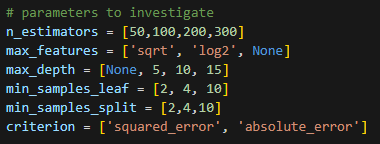


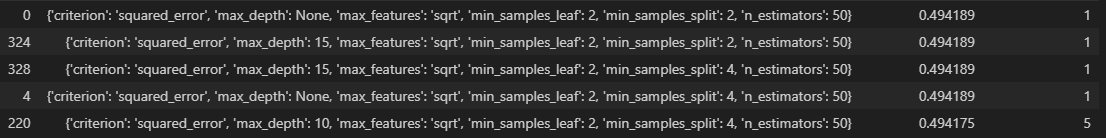

Looks like we should investigate fewer n_estimators and perhaps a higher max_depth (However, we should be aware of overfitting)

## 2nd iteration best results (exact same mean_test_error??):

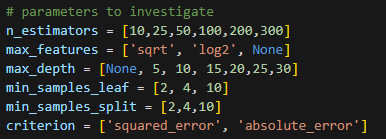

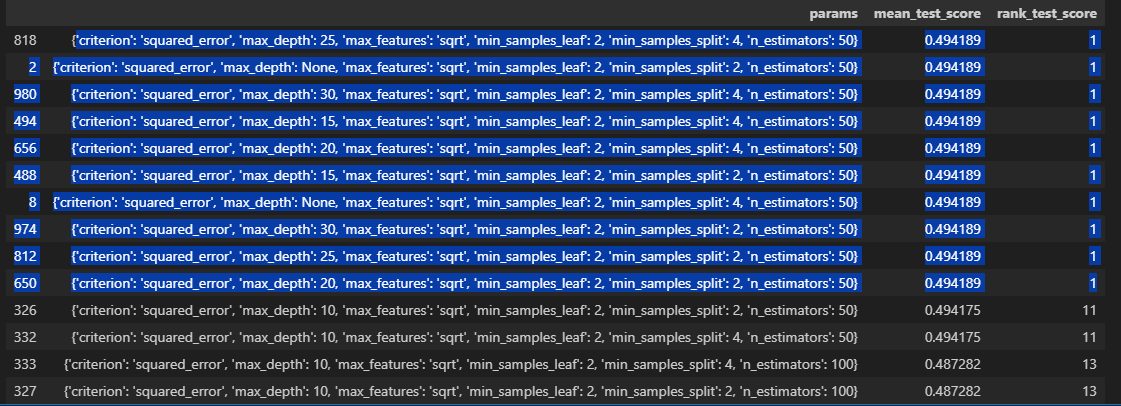


It looks like the max_depth is the most alternating parameter.
However, the investigation of the parameter is not that interesting...
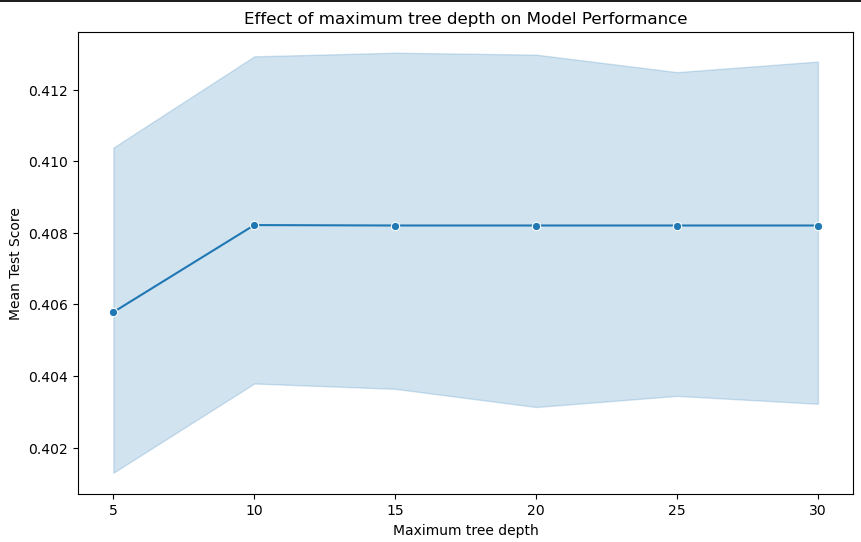

When we look at the performance (training vs. OOB):

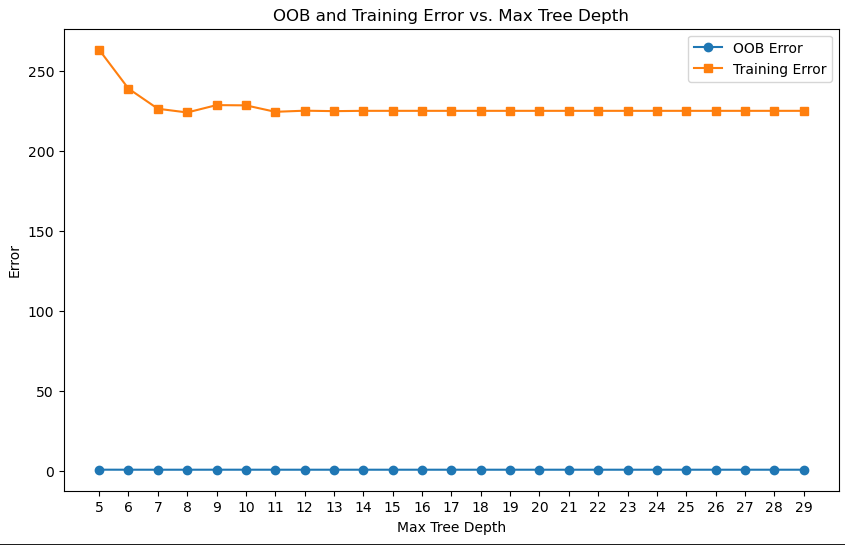

Which is not that exciting either...

# Code:

In [16]:
clf = RandomForestRegressor(random_state=0,oob_score=True)

# parameters to investigate
n_estimators = [10,25,50,100,200,300]
max_features = ['sqrt', 'log2', None]
max_depth = [None, 5, 10, 15,20,25,30]
min_samples_leaf = [2, 4, 10]
min_samples_split = [2,4,10]
criterion = ['squared_error', 'absolute_error']

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'criterion': criterion
}

# cv
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid,cv =5,verbose=2,n_jobs=-1)

# fit grid search model
rf_grid.fit(imputed_df,y)

df_results = pd.DataFrame(rf_grid.cv_results_)

Fitting 5 folds for each of 2268 candidates, totalling 11340 fits


KeyboardInterrupt: 

In [ ]:
# Sort by rank or performance
df_sorted = df_results.sort_values(by=['rank_test_score'])

pd.set_option('display.max_colwidth', None)
df_sorted[['params', 'mean_test_score', 'rank_test_score']][:14]

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='param_max_depth', y='mean_test_score', marker='o')
plt.title('Effect of maximum tree depth on Model Performance')
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean Test Score')
plt.show()

In [ ]:
max_depth_range = np.arange(5, 30, 1)
oob_errors = []
training_errors = []

for depth in max_depth_range:
    model = RandomForestRegressor(n_estimators=50, max_depth=depth, oob_score=True, random_state=0)
    model.fit(imputed_df, y)
    
    # Record the OOB error
    oob_error = 1 - model.oob_score_
    oob_errors.append(oob_error)
    
    # Record the training error
    training_predictions = model.predict(imputed_df)
    training_error = np.mean((y - training_predictions) ** 2)  # MSE as the training error
    training_errors.append(training_error)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, oob_errors, label='OOB Error', marker='o')
plt.plot(max_depth_range, training_errors, label='Training Error', marker='s')
plt.xlabel('Max Tree Depth')
plt.ylabel('Error')
plt.title('OOB and Training Error vs. Max Tree Depth')
plt.legend()
plt.xticks(max_depth_range)
plt.show()

# Elastic net

In [19]:
# transform y
y = preprocessing.StandardScaler().fit_transform(np.reshape(y.values, (-1,1)))

In [22]:
# Since RMSE is the required scoring parameter
# define RMSE scorer function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# make it into a default scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# rename design matrix for ease of use
X = imputed_df.copy()

# model definition
model = ElasticNet()

# choose param grid
param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'l1_ratio': np.linspace(0, 1, 5)
}

# try LOOCV for both inner and outer loops (could be costly :D)
outer_cv = LeaveOneOut()
inner_cv = 10

nested_scores = []

# Outer Loop
for train_index, test_index in outer_cv.split(X):
    print(test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Grid search with inner loop
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring=rmse_scorer)
    grid_search.fit(X_train, y_train)

    # Evaluate on the test data
    y_pred = grid_search.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    nested_scores.append(test_rmse)

    print(grid_search.best_estimator_)

# Report nested cross-validation RMSE
nested_rmse = np.mean(nested_scores)
print("Nested CV RMSE:", nested_rmse)



[0]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e-01, tolerance: 8.820e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[1]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e-01, tolerance: 8.997e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[2]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e-01, tolerance: 9.145e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[3]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.173e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[4]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e-01, tolerance: 9.172e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[5]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e-01, tolerance: 9.046e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[6]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e-01, tolerance: 9.137e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[7]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e-01, tolerance: 9.060e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[8]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e-01, tolerance: 9.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[9]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e-01, tolerance: 9.001e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[10]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[11]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e-01, tolerance: 8.921e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[12]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e-01, tolerance: 8.921e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[13]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e-01, tolerance: 8.963e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[14]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e-01, tolerance: 8.704e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[15]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e-01, tolerance: 8.771e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[16]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e-01, tolerance: 8.882e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[17]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e-01, tolerance: 8.961e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[18]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e-01, tolerance: 8.815e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[19]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e-01, tolerance: 8.947e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[20]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e-01, tolerance: 8.918e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 9.158e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[21]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e-01, tolerance: 8.018e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e-01, tolerance: 8.239e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[22]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e-01, tolerance: 8.934e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-01, tolerance: 9.168e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[23]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e-01, tolerance: 8.771e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e-01, tolerance: 9.014e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[24]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e-01, tolerance: 8.651e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e-01, tolerance: 8.879e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[25]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e-01, tolerance: 8.876e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 9.117e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[26]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-01, tolerance: 8.939e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e-01, tolerance: 9.178e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[27]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e-01, tolerance: 9.201e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[28]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e-01, tolerance: 8.964e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e-01, tolerance: 9.201e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[29]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e-01, tolerance: 9.202e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[30]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e-01, tolerance: 9.201e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[31]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e-01, tolerance: 8.922e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-01, tolerance: 9.155e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[32]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e-01, tolerance: 8.950e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 9.185e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[33]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-01, tolerance: 8.790e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 9.033e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[34]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e-01, tolerance: 8.946e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-01, tolerance: 9.185e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[35]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e-01, tolerance: 8.934e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 9.168e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[36]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e-01, tolerance: 8.955e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 9.193e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[37]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 9.186e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[38]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.153e-01, tolerance: 8.879e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-01, tolerance: 9.111e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[39]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e-01, tolerance: 9.202e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[40]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e-01, tolerance: 8.957e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 9.195e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[41]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e-01, tolerance: 8.911e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e-01, tolerance: 9.151e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[42]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.220e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e-01, tolerance: 9.202e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[43]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e-01, tolerance: 9.201e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.1, l1_ratio=0.25)
[44]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-01, tolerance: 8.584e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-01, tolerance: 8.811e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[45]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-01, tolerance: 8.941e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-01, tolerance: 9.180e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[46]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-01, tolerance: 8.896e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e-01, tolerance: 9.128e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[47]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e-01, tolerance: 8.966e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 9.202e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[48]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.015e-01, tolerance: 8.966e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e-01, tolerance: 9.202e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[49]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e-01, tolerance: 8.942e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.276e-01, tolerance: 9.181e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[50]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e-01, tolerance: 8.962e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e-01, tolerance: 9.197e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[51]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-01, tolerance: 8.961e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e-01, tolerance: 9.196e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[52]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e-01, tolerance: 8.953e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e-01, tolerance: 9.191e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[53]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e-01, tolerance: 8.430e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-01, tolerance: 8.678e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[54]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e-01, tolerance: 8.828e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e-01, tolerance: 9.059e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[55]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e-01, tolerance: 8.881e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e-01, tolerance: 9.113e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[56]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-01, tolerance: 8.947e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-01, tolerance: 9.185e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[57]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e-01, tolerance: 8.955e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e-01, tolerance: 9.190e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[58]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e-01, tolerance: 8.440e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e-01, tolerance: 8.665e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[59]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e-01, tolerance: 8.600e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 8.827e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[60]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e-01, tolerance: 8.911e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e-01, tolerance: 9.151e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[61]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.052e-01, tolerance: 8.932e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e-01, tolerance: 9.172e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[62]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e-01, tolerance: 8.922e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e-01, tolerance: 9.162e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[63]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-01, tolerance: 8.702e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e-01, tolerance: 8.947e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[64]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e-01, tolerance: 8.953e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e-01, tolerance: 9.191e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[65]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e-01, tolerance: 8.816e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e-01, tolerance: 9.058e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[66]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-01, tolerance: 8.782e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e-01, tolerance: 9.025e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[67]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e-01, tolerance: 9.201e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[68]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 8.948e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e-01, tolerance: 9.187e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[69]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.377e-01, tolerance: 8.893e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 9.134e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[70]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e-01, tolerance: 8.964e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e-01, tolerance: 9.201e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[71]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e-01, tolerance: 8.961e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 9.199e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[72]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e-01, tolerance: 8.956e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e-01, tolerance: 9.194e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[73]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e-01, tolerance: 8.890e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e-01, tolerance: 9.123e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[74]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e-01, tolerance: 8.962e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 9.200e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[75]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.359e-01, tolerance: 8.960e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-01, tolerance: 9.198e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[76]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.337e-01, tolerance: 8.707e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 8.951e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[77]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e-01, tolerance: 8.965e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e-01, tolerance: 9.202e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[78]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e-01, tolerance: 8.905e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e-01, tolerance: 9.138e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[79]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e-01, tolerance: 8.819e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e-01, tolerance: 9.049e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[80]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e-01, tolerance: 8.917e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 9.157e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[81]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e-01, tolerance: 8.942e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-01, tolerance: 9.181e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[82]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e-01, tolerance: 8.874e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-01, tolerance: 9.105e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[83]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e-01, tolerance: 8.905e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e-01, tolerance: 9.146e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[84]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e-01, tolerance: 8.563e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 8.790e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[85]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.096e-01, tolerance: 8.646e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e-01, tolerance: 8.873e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[86]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e-01, tolerance: 8.834e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.323e-01, tolerance: 9.064e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[87]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-01, tolerance: 8.776e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e-01, tolerance: 9.020e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[88]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e-01, tolerance: 8.783e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-01, tolerance: 9.027e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[89]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e-01, tolerance: 8.956e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e-01, tolerance: 9.191e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[90]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e-01, tolerance: 8.887e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-01, tolerance: 9.119e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[91]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e-01, tolerance: 8.563e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 8.810e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[92]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.217e-01, tolerance: 8.888e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e-01, tolerance: 9.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[93]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 8.959e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e-01, tolerance: 9.197e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[94]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.203e-01, tolerance: 8.820e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-01, tolerance: 9.051e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[95]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e-01, tolerance: 8.945e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e-01, tolerance: 9.184e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[96]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-01, tolerance: 8.638e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e-01, tolerance: 8.866e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[97]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e-01, tolerance: 8.966e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 9.202e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[98]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e-01, tolerance: 8.946e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e-01, tolerance: 9.181e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
[99]


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e-01, tolerance: 8.960e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e-01, tolerance: 9.198e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Use

ElasticNet(alpha=0.01, l1_ratio=1.0)
Nested CV RMSE: 0.35265344244401026


In [21]:
# Report nested cross-validation RMSE
nested_rmse = np.mean(nested_scores)
print("Nested CV RMSE:", nested_rmse)

Nested CV RMSE: 0.34919369478905354


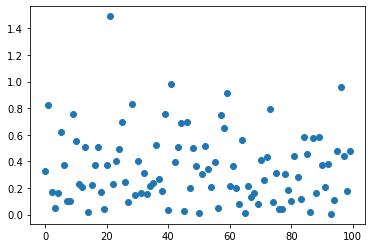

In [43]:
plt.scatter(x=imputed_df.index, y = nested_scores)